**이 노트북은 모델 구축에 필요한 데이터를 탐색하고 준비하는 방법을 설명합니다.<br>
노트북은 다음과 같이 조직됩니다.<br>**

**•About Dataset<br>
•Data Summary<br>
•Feature Engineering<br>
•Missing Value Analysis<br>
•Outlier Analysis<br>
•Correlation Analysis<br>
•Visualizing Distribution Of Data<br>
•Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)<br>
•Filling 0's In Windspeed Using Random Forest<br>
•Linear Regression Model<br>
•Regularization Models<br>
•Ensemble Models<br>**

*About Dataset*

**개요<br>
자전거 공유 시스템은 도시 전체의 키오스크 위치망을 통해 회원가입, 대여, 자전거 반납 절차가 자동화되는 자전거를 대여하는 수단입니다. 이러한 시스템을 사용하면 사람들은 한 장소에서 자전거를 대여하여 필요에 따라 다른 장소로 반납할 수 있습니다. 현재 전세계에 500개가 넘는 자전거 공유 프로그램이 있습니다.**

**Data Fields**<br><br>

**•datetime - hourly date + timestamp<br>
•season - 1 = spring, 2 = summer, 3 = fall, 4 = winter<br>
•holiday - whether the day is considered a holiday<br>
•workingday - whether the day is neither a weekend nor holiday<br>
•weather -<br>
    ▪︎1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>
    ▪︎2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>
    ▪︎3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
    ▪︎4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog<br>
•temp - temperature in Celsius<br>
•atemp - "feels like" temperature in Celsius<br>
•humidity - relative humidity<br>
•windspeed - wind speed<br>
•casual - number of non-registered user rentals initiated<br>
•registered - number of registered user rentals initiated<br>
•count - number of total rentals (Dependent Variable)<br>**

In [100]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [101]:
!ls

 김영협_1_Bike_Sharing_Demand.ipynb	       '[E-8]make_a_portrait.ipynb'
 김영협_1_Titanic.ipynb			        face_embedding
 김영협_2_Titanic.ipynb			        human_segmentation
 array_archive.npz			        image.jpeg
 arrays_compressed.npz			        image.png
 bike_predictions_gbm_separate_without_fe.csv   images1.png
 Bike_test.csv				        kaggle_kakr_housing
 Bike_train.csv				        lost+found
 camera_sticker				        lyricist
 data_preprocess			        pokemon
 data_represent				        pokemon_eda
 data_visualization			        python_image_proc
 DuSiDataTeam4				        rock_scissor_paper
'[E-1]rock_scissor_paper.ipynb'		        rock_scissor_paper_test
'[E-3]camera_sticker.ipynb'		        sentiment_classification
'[E-4]lyric_writer.ipynb'		        some_array.npy
'[E-5]celebrity1.ipynb'			        train_1.csv
'[E-5]celebrity.ipynb'			        train.csv
'[E-7]estimation_analysis.ipynb'


**Lets Read In The Dataset**

In [102]:
dailyData = pd.read_csv("../aiffel/train.csv") #..은 상위폴더로 갈 수 있는 것!

*Data Summary*

**첫 번째 단계로 데이터셋에 대해 세 가지 간단한 단계를 수행합니다.<br>**

**1단계 : 데이터셋의 크기<br>
2단계 : 데이터 행을 몇 줄 인쇄하여 데이터를 한눈에 보기<br>
3단계 : 어떤 유형의 변수가 데이터에 기여하는지<br>**

**Shape Of The Dataset**

In [103]:
dailyData.shape

(10886, 12)

**Sample Of First Few Rows**

In [104]:
dailyData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


**Variables Data Type**

In [105]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

*Feature Engineering*

**위의 결과에서 알 수 있듯이, "계절", "휴일", "근무일" 및 "날씨" 열은 "Categorical" 데이터 유형이어야 합니다.<br>
그러나 현재 데이터 유형은 해당 열의 "int"입니다. 데이터셋을 다음과 같은 방법으로 변환하여 EDA를 시작할 수 있도록 지원합니다.**

**•"datetime" 열에서 "date", "hour", "weekDay", "month" 열을 만듭니다.<br>
•"계절", "휴일", "근무일" 및 날씨의 데이터 유형을 카테고리로 강제 지정합니다.<br>
•날짜 시간 열에서 유용한 기능을 이미 추출했으므로 해당 열을 삭제하십시오.**

**"Datetime" 열에서 새 열 작성**

In [106]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

*Coercing To Category Type*

In [107]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

*Dropping Unncessary Columns*

In [108]:
dailyData  = dailyData.drop(["datetime"],axis=1)

*Lets Start With Very Simple Visualization Of Variables DataType Count*

<AxesSubplot:xlabel='variableType', ylabel='count'>

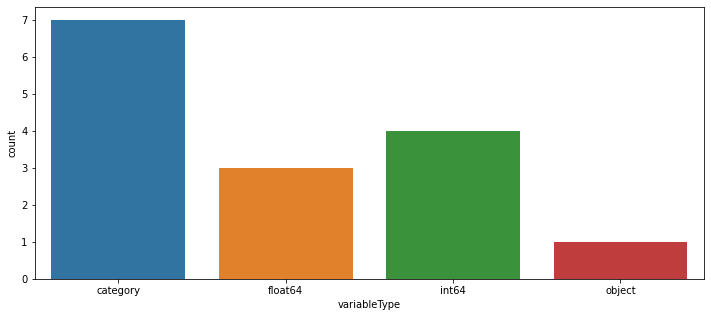

In [109]:
#dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
#fig,ax = plt.subplots()
#fig.set_size_inches(12,5)
#sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
#ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

typesCountSerie = dailyData.dtypes.value_counts()

#format columns as arrays of either strings or integers
#typeNames are easier to sort as array of 'string' rather than an array of 'dtype'
typeNamesColumn = list(map(lambda t: t.name , typesCountSerie.index.values));
typeCountColumn = typesCountSerie.values

#create an initial dataframe, with multiple occurences of the same "variableType"
intialDataTypeDf = pd.DataFrame({
    "variableType" : typeNamesColumn,
    "count" : typeCountColumn
})

groupedDataTypeDf = intialDataTypeDf.groupby(['variableType']).sum()[['count']].reset_index()

fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=groupedDataTypeDf, x="variableType",y="count", ax=ax)


*Missing Values Analysis*

**데이터와 열을 파악한 후 다음 단계는 일반적으로 데이터에 결측값이 있는지 여부를 확인하는 것입니다. 다행히 데이터셋에 결측값이 없습니다.<br>
일반적으로 데이터 집합의 결측값을 시각화하는 방법 중 하나는 "missingno"를 사용하는 것입니다.<br>
결측값에 대한 변수를 빠르게 시각화할 수 있는 조용하고 편리한 라이브러리입니다.**<br>

**Skewness In Distribution**

<AxesSubplot:>

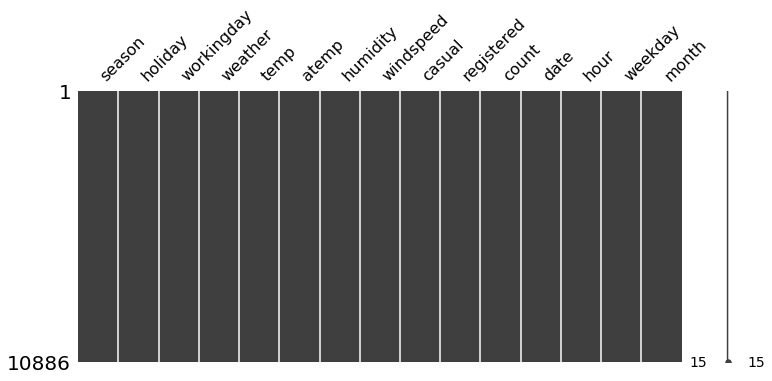

In [110]:
msno.matrix(dailyData,figsize=(12,5)) #결측값이 없어서 빈틈없이 모두 검정색으로 출력됐습니다.

*Outliers Analysis*

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

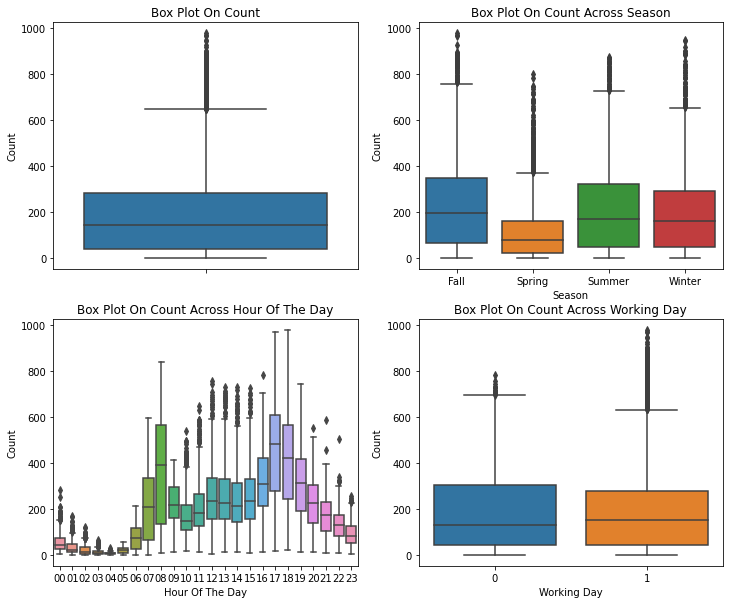

In [111]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

**Lets Remove Outliers In The Count Column**

In [112]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())]

In [113]:
print ("Shape Of The Before Ouliers: ",dailyData.shape) #Ouliers의 유무가 데이터수에 영향을 미칩니다!
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


*Correlation Analysis*

**종속 변수가 feature(numerical)의 영향을 받는 방식을 이해하는 일반적인 방법 중 하나는 변수 간의 상관 행렬을 피브?하는 것입니다.<br>
"count"와 "temp", "atemp", "humidity", "windspeed" 사이의 상관 관계 그림을 그려보겠습니다.**

**•temp 및 humidity features는 각각 count와 양의 상관관계 및 음의 상관관계를 가집니다.이들 간의 상관 관계는 그다지 두드러지지는 않지만 count 변수는 "temp"와 "humidity"에 거의 의존하지 않습니다.<br>
•windspeed는 실제로 유용한 수치적 특성은 아닐 것이며 "count"와의 상관 관계 값에서 볼 수 있습니다.<br>
•"atemp"와 "temp"가 서로 강한 상관관계를 가지고 있기 때문에 "atemp"는 변수화되지 않습니다. 모델 작성 중에 변수 중 하나는 데이터에 다중 공선성을 나타내므로 삭제해야 합니다.<br>
•"Casual" 및 "Registered"도 본질적으로 누출 변수이므로 모델 구축 중에 삭제해야 하기 때문에 고려되지 않습니다.**

**seaborn의 Regression plot은 두 features 간의 관계를 묘사하는 유용한 방법 중 하나입니다. 여기서는 "count" 대 "temp", "humidity", "windspeed"를 고려합니다.**

<AxesSubplot:>

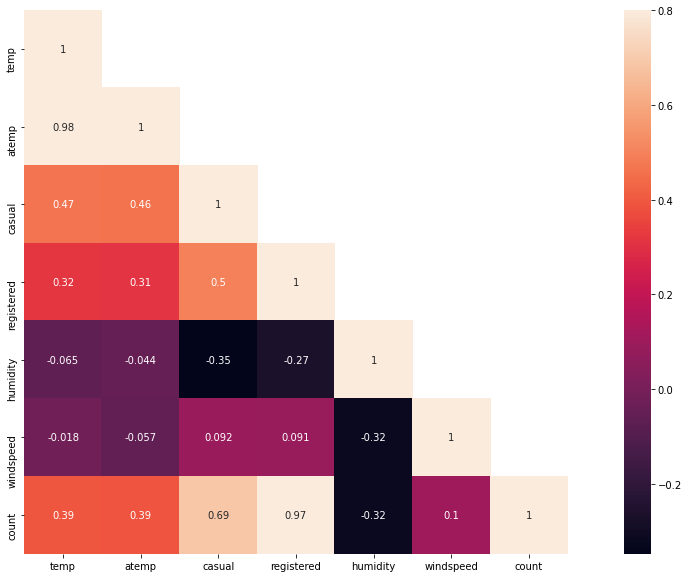

In [114]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

<AxesSubplot:xlabel='humidity', ylabel='count'>

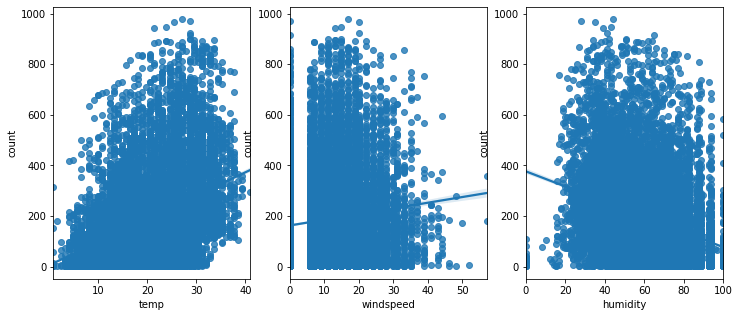

In [115]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="count", data=dailyData,ax=ax2)
sn.regplot(x="humidity", y="count", data=dailyData,ax=ax3)

*Visualizing Distribution Of Data*

**아래 그림에서 볼 수 있듯이 "count" 변수는 오른쪽으로 치우쳐 있습니다. 대부분의 머신 러닝 기술에서는 종속 변수가 정규 분포여야 하므로 정규 분포를 따르는 것이 좋습니다. 한 가지 가능한 해결책은 특이치 데이터 점을 제거한 후 "count" 변수에 대한 로그 변환을 수행하는 것입니다. 변환 후 데이터는 훨씬 좋아 보이지만 여전히 이상적으로는 정규 분포를 따르지 않습니다.**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909617))

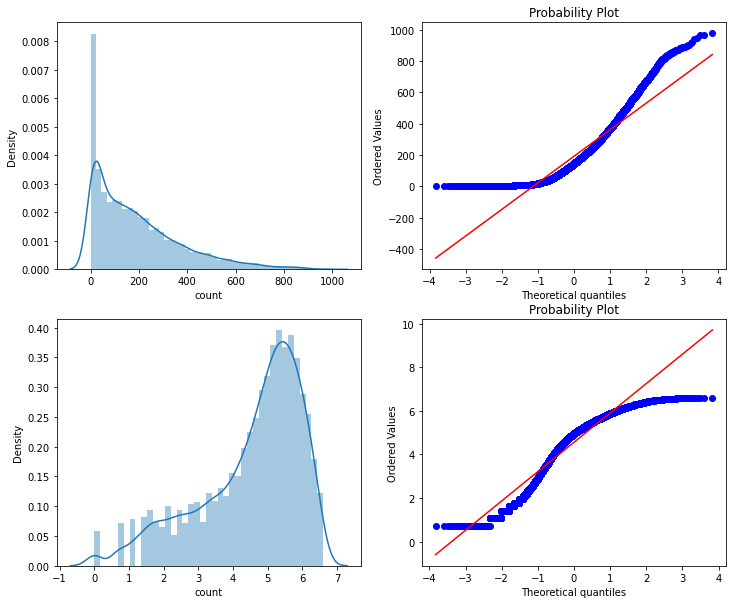

In [116]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["count"],ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

*Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)*

**•여름철에는 자전거를 타는 것이 매우 좋기 때문에 사람들이 자전거를 빌리는 경향이 있는 것은 매우 명백합니다.<br>
 따라서 6월, 7월, 8월은 자전거에 대한 수요가 상대적으로 더 높았습니다.<br>
•평일에는 오전 7-8시, 오후 5-6시 경에 자전거를 대여하는 사람들이 많아지고 있습니다.<br> 
 앞에서 언급했듯이 이것은 정규 학교 및 사무실 통근자들에게 기인할 수 있습니다.<br>
•위의 패턴은 "토요일" 및 "일요일"에는 관찰되지 않습니다.오전 10시에서 오후 4시 사이에 자전거를 대여하는 사람들이 늘고 있습니다.<br>
 약 7AM-8AM 및 5PM-6PM의 최대 사용자 수는 등록된 사용자가 전적으로 기여합니다.**

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

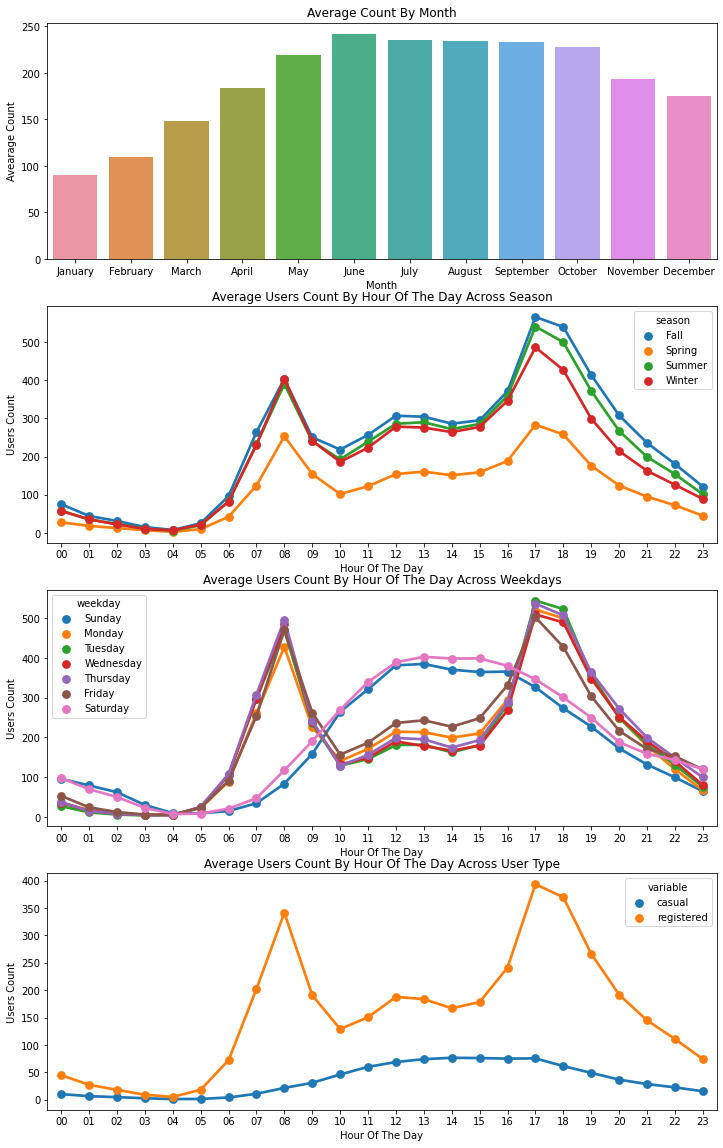

In [117]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

**우리는 데이터를 더 많이 시각화했습니다.<br> 
이제 몇 가지 모델을 제작하여 결과를 얼마나 근접하게 예측할 수 있는지 살펴보겠습니다.**

*Filling 0's In windspeed Using Random Forest*

**Lets Read In Train And Test Data**

In [118]:
dataTrain = pd.read_csv("../aiffel/Bike_train.csv")
dataTest = pd.read_csv("../aiffel/Bike_test.csv")

**Combine Train And Test**

In [119]:
data = dataTrain.append(dataTest)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

**Feature Engineering**

In [120]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

**Random Forest Model To Predict 0's In Windspeed**

In [121]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

**Coercing To Categorical Type**

In [122]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [123]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

**Splitting Train And Test Data**

In [124]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

**Dropping Unncessary Variables**

In [125]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

**RMSLE Scorer**

In [126]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

*Linear Regression Model*

In [127]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(X = dataTrain,y = yLabelsLog)

# Make predictions
preds = lModel.predict(X= dataTrain)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Linear Regression:  0.9779704078631746


**Regularization Model - Ridge**

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9779703927883744


<AxesSubplot:xlabel='param_alpha', ylabel='mean_test_score'>

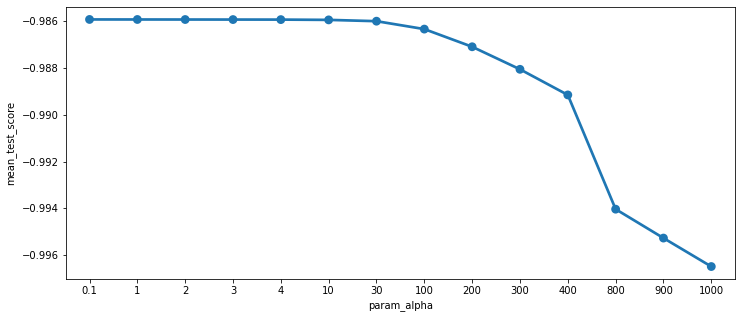

In [128]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit( dataTrain, yLabelsLog )
preds = grid_ridge_m.predict(X= dataTrain)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
#df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
#df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sn.pointplot(data=df,x=df["param_alpha"],y=df["mean_test_score"],ax=ax)

**Regularization Model - Lasso**

{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9781074279813088


<AxesSubplot:xlabel='param_alpha', ylabel='mean_test_score'>

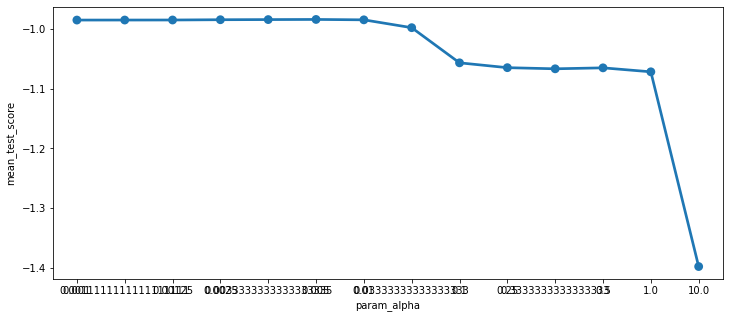

In [131]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit( dataTrain, yLabelsLog )
preds = grid_lasso_m.predict(X= dataTrain)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.cv_results_)
#df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
#df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sn.pointplot(data=df,x=df["param_alpha"],y=df["mean_test_score"],ax=ax)

**Ensemble Models - Random Forest**

In [132]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest:  0.10324321817173222


**Ensemble Model - Gradient Boost**

In [133]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.18919276665098592


**train의 분포와 test 결과를 비교해봅시다.<br>
train과 test의 분포는 다소 같아 보입니다. 이는 우리 모델이 심각한 overfitting 문제를 겪지 않을 것이라고 시각적으로 예측했음을 확인시켜줍니다!**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

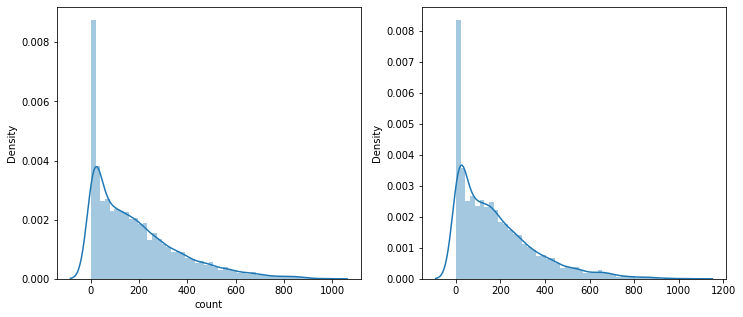

In [134]:
predsTest = gbm.predict(X= dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot(yLabels,ax=ax1,bins=50)
sn.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [135]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)

**제출 시 test score는 0.41점입니다.**